<a href="https://colab.research.google.com/github/jamienkp/COMP6781/blob/main/Project/COMP6781_Harpreet_Kaur_40336094_MaryAnn_NGKWETPIN_40336644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual AI Generated text dectection using comparative classification models

# Description of the project


This project focuses on detecting AI-generated text in multiple languages, specifically English and Chinese. The goal is to compare three different classification approaches to see which one performs best at distinguishing between human-written and machine-generated text.

We compare three different approaches to identify AI-generated and human-written text across multiple languages:

1. Multinomial Naive Bayes (MNB) + TF-IDF:
2. FastText + Feedforward Neural Network (FNN):
3. Multilingual BERT (mBERT):

All three models will be trained and tested on the same data splits for fairness and evaluated using accuracy, precision, recall, and F1-score. Confusion matrices will be used to analyze errors, and the results will highlight each model’s strengths and trade-offs in accuracy, speed, and multilingual performance.

## Data preprocessing

In this section, we load the dataset and filter it to include only English and Chinese samples. The text is then cleaned using lowercasing for English and Jieba tokenization for Chinese, followed by the creation of balanced train, validation, and test splits to ensure fairness across all models.

In [ ]:
!pip install torch torchvision torchaudio -q
!pip install transformers datasets evaluate scikit-learn fasttext tqdm matplotlib seaborn -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import jieba

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from datasets import load_dataset


/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


In [ ]:
ds = load_dataset("Jinyan1/COLING_2025_MGT_multingual")
print(ds)

train_df = pd.DataFrame(ds["train"])
val_df   = pd.DataFrame(ds["dev"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/589 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/674083 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/288894 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 674083
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 288894
    })
})


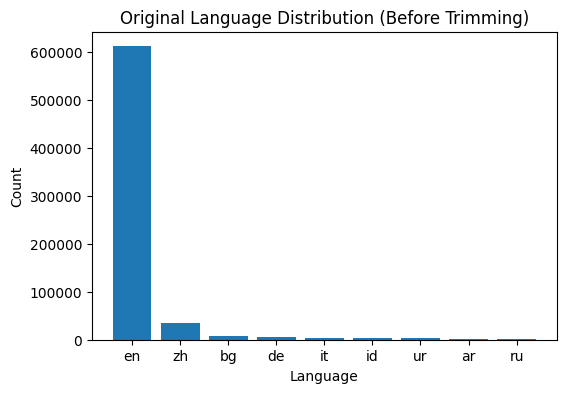

,count
lang,
en,610676
zh,35284
bg,8091
de,4693
it,4174
id,3976
ur,3761
ar,2114
ru,1314


In [ ]:
# Before trimming distribution
orig_counts = train_df["lang"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(orig_counts.index, orig_counts.values)
plt.title("Original Language Distribution (Before Trimming)")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()

orig_counts


In [ ]:
train_df = train_df[train_df["lang"].isin(["en", "zh"])].reset_index(drop=True)
val_df   = val_df[val_df["lang"].isin(["en", "zh"])].reset_index(drop=True)

print("Train:", train_df.shape)
print("Dev:", val_df.shape)
print("\nLanguage distribution (train):")
print(train_df["lang"].value_counts())
print("\nLanguage distribution (validation):")
print(val_df["lang"].value_counts())

Train: (645960, 7)
Dev: (276621, 7)

Language distribution (train):
lang
en    610676
zh     35284
Name: count, dtype: int64

Language distribution (validation):
lang
en    261849
zh     14772
Name: count, dtype: int64


In [ ]:
# Balance EN and ZH in train set by trimming EN down to match ZH count
balanced_size_train = train_df['lang'].value_counts().min()

train_df = train_df.groupby("lang").apply(
    lambda x: x.sample(n=balanced_size_train, random_state=42)
).reset_index(drop=True)

print("Balanced training counts:", train_df['lang'].value_counts().to_dict())


/tmp/ipython-input-564701133.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("lang").apply(


Balanced training counts: {'en': 35284, 'zh': 35284}


In [ ]:
train_df["label"] = train_df["label"].astype(int)
val_df["label"]   = val_df["label"].astype(int)

def clean_text(text, lang):
    text = str(text).replace("\n", " ").strip()
    if lang == "en":
        text = text.lower()
    if lang == "zh":
        seg_list = jieba.cut(text)
        text = " ".join(seg_list) # join chinese token with spaces
    return text

# drop empty / NaN text produced by cleaning
train_df = train_df.dropna(subset=["text"]).reset_index(drop=True)
val_df   = val_df.dropna(subset=["text"]).reset_index(drop=True)

# ensure labels are integer
train_df["label"] = train_df["label"].astype(int)
val_df["label"]   = val_df["label"].astype(int)


In [ ]:
# create ttrain and test splits so En and zh are split fairly with same label ratio
def create_test_split(df, test_size=0.1, seed=42):
    train_parts, test_parts = [], []
    for lang in df["lang"].unique():
        subset = df[df["lang"] == lang]
        train_split, test_split = train_test_split(
            subset, test_size=test_size,
            stratify=subset["label"], random_state=seed   # keep the same human and ai ratio and make the split reproducible
        )
        train_parts.append(train_split)
        test_parts.append(test_split)
    return pd.concat(train_parts), pd.concat(test_parts)

train_df, test_df = create_test_split(train_df)

In [ ]:
for lang in ["en", "zh"]:
    print(f"\nLanguage: {lang}")
    print("Train:", train_df[train_df["lang"] == lang]["label"].value_counts().to_dict())
    print("Val:",   val_df[val_df["lang"] == lang]["label"].value_counts().to_dict())
    print("Test:",  test_df[test_df["lang"] == lang]["label"].value_counts().to_dict())


Language: en
Train: {1: 19770, 0: 11985}
Val: {1: 163808, 0: 98041}
Test: {1: 2197, 0: 1332}

Language: zh
Train: {0: 17383, 1: 14372}
Val: {0: 8023, 1: 6749}
Test: {0: 1932, 1: 1597}


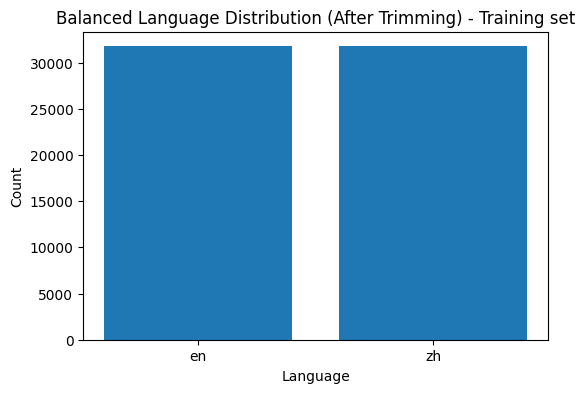

In [ ]:
after_counts = train_df['lang'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(after_counts.index, after_counts.values)
plt.title("Balanced Language Distribution (After Trimming) - Training set")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()



## Model Development and Training


### Model 1 - Multinomial Naive Bayes with TF-IDF

For each language, we build a separate model by converting the text into TF-IDF features using unigrams and bigrams, capturing both word frequency and short contextual patterns. The TF-IDF vectors are then used to train a Multinomial Naive Bayes classifier.

We evaluate each language-specific model independently using accuracy, precision, recall, F1-score, and confusion matrices. This provides a clear view of how well MNB performs on English vs. Chinese, and also allows us to compare it fairly with the other two models in the project.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
def prepare_tfidf_data(train_df, val_df, test_df, language):
    """Vectorize text using TF-IDF for a specific language."""
    train_lang = train_df[train_df["lang"] == language]
    val_lang   = val_df[val_df["lang"] == language]
    test_lang  = test_df[test_df["lang"] == language]

    # create tfidf vectorizer using unigram and bigrams
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        sublinear_tf=True
    )

    # fit tfidf in training and transform validation and test data
    X_train = vectorizer.fit_transform(train_lang["text"])
    X_val   = vectorizer.transform(val_lang["text"])
    X_test  = vectorizer.transform(test_lang["text"])

    y_train = train_lang["label"].values
    y_val   = val_lang["label"].values
    y_test  = test_lang["label"].values

    return X_train, y_train, X_val, y_val, X_test, y_test, vectorizer

In [ ]:
def train_mnb(X_train, y_train):
    """Train the Multinomial Naive Bayes model."""
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model

In [ ]:
def evaluate_mnb(model, X_test, y_test, language):
    """Evaluate the MNB model on test data."""
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print(f"\n{language.upper()} RESULTS")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human", "AI"],
                yticklabels=["Human", "AI"])
    plt.title(f"MNB Confusion Matrix – {language.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"language": language, "accuracy": acc,
            "precision": prec, "recall": rec, "f1": f1}


===== Running MNB for EN =====

EN RESULTS
Accuracy : 0.6639
Precision: 0.7588
Recall   : 0.6746
F1-score : 0.7142


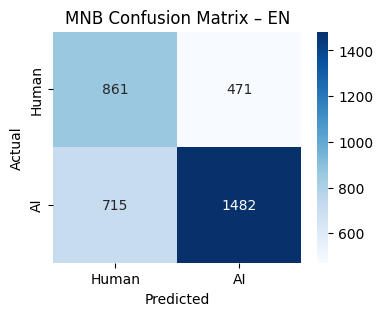


===== Running MNB for ZH =====

ZH RESULTS
Accuracy : 0.8033
Precision: 0.8823
Recall   : 0.6525
F1-score : 0.7502


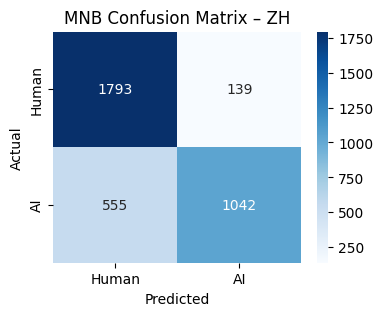

In [ ]:
results = []
for lang in ["en", "zh"]:
    print(f"\n===== Running MNB for {lang.upper()} =====")

    X_train, y_train, X_val, y_val, X_test, y_test, vectorizer = prepare_tfidf_data(
        train_df, val_df, test_df, lang
    )

    model = train_mnb(X_train, y_train)

    result = evaluate_mnb(model, X_test, y_test, lang)
    results.append(result)

In [ ]:
results_df = pd.DataFrame(results)
print("\n===== MNB Summary =====")
print(results_df)


===== MNB Summary =====
  language  accuracy  precision    recall        f1
0       en  0.663927   0.758833  0.674556  0.714217
1       zh  0.803344   0.882303  0.652473  0.750180


In [ ]:
from random import sample

def show_sample_predictions(model, vectorizer, test_df, language, n=5):
    """Display a few text samples with actual vs predicted labels."""
    # Filter language
    test_lang = test_df[test_df["lang"] == language].copy()
    sample_rows = test_lang.sample(n=n, random_state=42)

    # Vectorize text
    X_sample = vectorizer.transform(sample_rows["text"])
    y_pred = model.predict(X_sample)

    # Convert numeric labels back to text
    label_map = {0: "Human", 1: "AI"}
    sample_rows["Actual Label"] = sample_rows["label"].map(label_map)
    sample_rows["Predicted Label"] = [label_map[p] for p in y_pred]

    print(f"\nSample predictions for {language.upper()} model:\n")
    for i, row in sample_rows.iterrows():
        print(f"Text: {row['text'][:150]}...")
        print(f"→ Actual: {row['Actual Label']} | Predicted: {row['Predicted Label']}")
        print("-" * 80)

In [ ]:
for lang in ["en", "zh"]:
    # Recreate data + model for this language to get vectorizer
    X_train, y_train, X_val, y_val, X_test, y_test, vectorizer = prepare_tfidf_data(
        train_df, val_df, test_df, lang
    )
    model = train_mnb(X_train, y_train)
    show_sample_predictions(model, vectorizer, test_df, lang, n=5)


Sample predictions for EN model:

Text: It was a really cold winter morning and my friends had a stupid idea. They filled water balloons with water and left them outside overnight. In the mo...
→ Actual: AI | Predicted: Human
--------------------------------------------------------------------------------
Text: This paper reviews the economic and theoretical foundations of insolvency
risk measurement and capital adequacy rules. The proposed new measure of
ins...
→ Actual: Human | Predicted: AI
--------------------------------------------------------------------------------
Text: What the Rose did to the Cypress is a Persian fairy tale. Andrew Lang included it in The Brown Fairy Book (1904), with the note "Translated from two P...
→ Actual: Human | Predicted: Human
--------------------------------------------------------------------------------
Text: Eh. For someone who was on their first visit to Vegas, I sure wasn't impressed. The outside and inside are completely tacky. I only staye

#### **Analysis**

From the results, we can see that the Multinomial Naive Bayes model performs very differently on English and Chinese.

------ English (EN) -------

Accuracy: 0.663927

F1-score: 0.714217

The confusion matrix shows that the model often confuses human and AI English texts. This happens because the English dataset is very large and contains many writing styles, so TF-IDF alone is not strong enough to capture deeper patterns. Since MNB mostly relies on word frequency and short n-grams, it struggles with the more varied English vocabulary.

----- Chinese (ZH) -------

Accuracy: 0.803344

F1-score: 0.750180

The model does much better on Chinese. The confusion matrix shows fewer mistakes, meaning the TF-IDF features are more consistent for Chinese text. Using Jieba tokenization also helps because it segments the text into clearer word units. The Chinese dataset is also smaller and less diverse, which makes the patterns easier for MNB to learn.

**Overall**

Model 1 works better for Chinese than English. It gives us a good baseline, but it clearly has limitations, especially for English. This shows why we need more powerful models like FastText and mBERT, which can capture more context and handle multilingual data better.

### Model 2 - Word embedding model with FastText

For this model, we use pretrained FastText word embeddings to turn each sentence into a numerical vector. FastText works well for multilingual text because it understands subword patterns, which helps especially for Chinese. After we convert each sentence into an average embedding, we pass it into a small feedforward neural network (FNN) that predicts whether the text is human-written or AI-generated.

We train the model on balanced English and Chinese samples to keep things fair. Then we evaluate it using accuracy, precision, recall, F1-score, confusion matrices, and a few sample predictions to see how well it works on both languages.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz

!gunzip cc.en.300.vec.gz
!gunzip cc.zh.300.vec.gz


!pip install gensim -q


from gensim.models import KeyedVectors

ft_models = {
    "en": KeyedVectors.load_word2vec_format("cc.en.300.vec", binary=False),
    "zh": KeyedVectors.load_word2vec_format("cc.zh.300.vec", binary=False)
}



--2025-11-27 03:52:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  22.1MB/s    in 28s     

2025-11-27 03:52:32 (45.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2025-11-27 03:52:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1358817100 (1.3G) [binary/octet-stream]
Saving to: ‘cc.zh.30

In [ ]:
def get_sentence_embedding(sentence, lang):
    """Return mean FastText embedding for a sentence using gensim KeyedVectors."""
    words = sentence.split()
    model = ft_models[lang]   # select the FastText model for the correct lan
    vectors = [model[w] for w in words if w in model]  # collect emb for words that exist in FastText vocab
    if len(vectors) == 0:
        return np.zeros(model.vector_size) # if no words have emb, return a zero vector
    return np.mean(vectors, axis=0)


def build_embedding_matrix(df):
    """Build embeddings + labels tensors for a dataframe."""
    embeddings, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        emb = get_sentence_embedding(row["text"], row["lang"])  # compute fastText emb for the sentence
        embeddings.append(emb)
        labels.append(row["label"]) # store the corresponding label
    return torch.tensor(np.vstack(embeddings), dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


In [ ]:
train_small = train_df.groupby("lang").apply(lambda x: x.sample(n=len(x), random_state=42))   # use all data for each lang

train_small.index = train_small.index.droplevel(0) # Remove multi-index
val_small = val_df.copy()

test_small = test_df.groupby("lang").apply(
    lambda x: x.sample(n=len(x), random_state=42)   # use all test data
)
# Remove multi-index for test_small
test_small.index = test_small.index.droplevel(0)

X_train, y_train = build_embedding_matrix(train_small)
X_val,   y_val   = build_embedding_matrix(val_small)
X_test,  y_test  = build_embedding_matrix(test_small)


/tmp/ipython-input-2986824714.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_small = train_df.groupby("lang").apply(lambda x: x.sample(n=len(x), random_state=42))   # use all data for each lang
/tmp/ipython-input-2986824714.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_small = test_df.groupby("lang").apply(
100%|██████████| 7058/7058 [00:04<00:00, 1747.88it/s]


In [ ]:
from torch.utils.data import DataLoader, TensorDataset


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

print(" DataLoaders created and ready for training")


 DataLoaders created and ready for training


In [ ]:
class FNNClassifier(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=2):
        super(FNNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNNClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")


torch.save(model.state_dict(), "fnn_final.pt")


Epoch 1/5: 100%|██████████| 993/993 [00:07<00:00, 124.34it/s]


Epoch 1 | Train Loss: 0.6316


Epoch 2/5: 100%|██████████| 993/993 [00:05<00:00, 196.76it/s]


Epoch 2 | Train Loss: 0.6024


Epoch 3/5: 100%|██████████| 993/993 [00:04<00:00, 212.26it/s]


Epoch 3 | Train Loss: 0.5862


Epoch 4/5: 100%|██████████| 993/993 [00:07<00:00, 140.94it/s]


Epoch 4 | Train Loss: 0.5760


Epoch 5/5: 100%|██████████| 993/993 [00:04<00:00, 218.89it/s]


Epoch 5 | Train Loss: 0.5681


In [ ]:
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)

            all_preds += preds.cpu().tolist()
            all_labels += y.cpu().tolist()

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return acc, prec, rec, f1


In [ ]:
model.load_state_dict(torch.load("fnn_final.pt"))
model.eval()

test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader)

print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1: {test_f1:.4f}")



Test Results:
Accuracy: 0.6860 | Precision: 0.7842 | Recall: 0.5738 | F1: 0.6627


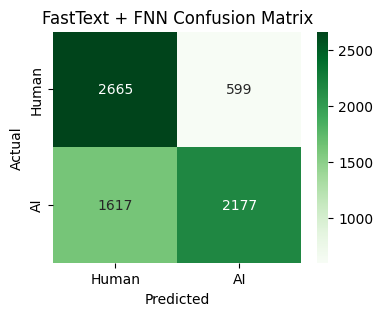

In [ ]:
# Confusion Matrix
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = torch.argmax(model(X), dim=1)
        all_preds += preds.cpu().tolist()
        all_labels += y.cpu().tolist()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Human","AI"], yticklabels=["Human","AI"])
plt.title("FastText + FNN Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


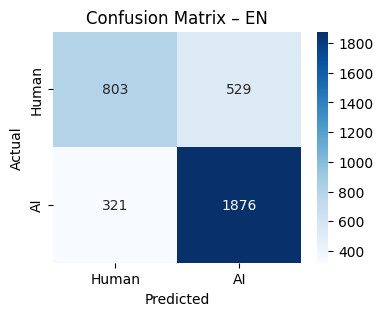

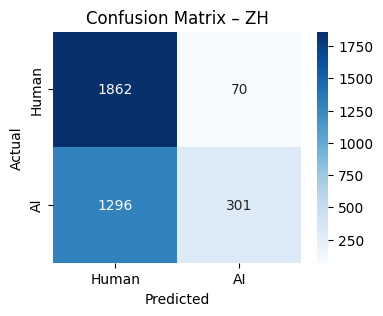

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_by_language(model, df):
    label_map = {0: "Human", 1: "AI"}
    for lang in ["en", "zh"]:
        subset = df[df["lang"] == lang]
        X = torch.tensor(
            np.vstack(subset.apply(lambda r: get_sentence_embedding(r["text"], r["lang"]), axis=1)),
            dtype=torch.float32
        ).to(device)
        y_true = subset["label"].values
        preds = torch.argmax(model(X), dim=1).cpu().numpy()

        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Human","AI"], yticklabels=["Human","AI"])
        plt.title(f"Confusion Matrix – {lang.upper()}")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()

plot_confusion_by_language(model, test_df)


In [ ]:
from sklearn.metrics import classification_report

def evaluate_per_language(model, df):
    label_map = {0: "Human", 1: "AI"}
    results = {}

    for lang in ["en", "zh"]:
        subset = df[df["lang"] == lang]
        X = torch.tensor(
            np.vstack(subset.apply(lambda r: get_sentence_embedding(r["text"], r["lang"]), axis=1)),
            dtype=torch.float32
        ).to(device)
        y_true = subset["label"].values
        preds = torch.argmax(model(X), dim=1).cpu().numpy()

        report = classification_report(y_true, preds, target_names=["Human", "AI"], output_dict=True)
        results[lang] = {
            "accuracy": accuracy_score(y_true, preds),
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1": report["weighted avg"]["f1-score"],
        }

    return pd.DataFrame(results).T

# Evaluate per language
lang_metrics = evaluate_per_language(model, test_df)
print("\n Per-Language Evaluation Metrics:")
display(lang_metrics)



 Per-Language Evaluation Metrics:


,accuracy,precision,recall,f1
en,0.759139,0.755270,0.759139,0.754382
zh,0.612922,0.689944,0.612922,0.538970


In [ ]:
def show_fasttext_samples(model, df, n=3):
    """Show FastText predictions for both English and Chinese examples."""
    model.eval()
    label_map = {0: "Human", 1: "AI"}

    for lang in ["en", "zh"]:
        subset = df[df["lang"] == lang]
        sample_rows = subset.sample(n=min(n, len(subset)), random_state=42)

        X = torch.tensor(
            np.vstack(sample_rows.apply(lambda r: get_sentence_embedding(r["text"], r["lang"]), axis=1)),
            dtype=torch.float32
        ).to(device)

        preds = torch.argmax(model(X), dim=1).cpu().numpy()
        sample_rows["Predicted"] = [label_map[p] for p in preds]
        sample_rows["Actual"] = sample_rows["label"].map(label_map)

        print(f"\nSample predictions for {lang.upper()} ({len(sample_rows)} examples):\n")
        for _, r in sample_rows.iterrows():
            print(f"Text: {r['text'][:120]}...")
            print(f"→ Actual: {r['Actual']} | Pred: {r['Predicted']}")
            print("-" * 80)

show_fasttext_samples(model, test_df, n=5)



Sample predictions for EN (5 examples):

Text: It was a really cold winter morning and my friends had a stupid idea. They filled water balloons with water and left the...
→ Actual: AI | Pred: AI
--------------------------------------------------------------------------------
Text: This paper reviews the economic and theoretical foundations of insolvency
risk measurement and capital adequacy rules. T...
→ Actual: Human | Pred: AI
--------------------------------------------------------------------------------
Text: What the Rose did to the Cypress is a Persian fairy tale. Andrew Lang included it in The Brown Fairy Book (1904), with t...
→ Actual: Human | Pred: AI
--------------------------------------------------------------------------------
Text: Eh. For someone who was on their first visit to Vegas, I sure wasn't impressed. The outside and inside are completely ta...
→ Actual: Human | Pred: Human
--------------------------------------------------------------------------------
Text: 

#### **Analysis**


Overall Performance:
Accuracy: 0.6860
Precision: 0.7842
Recall: 0.5738
F1-score: 0.6627


These scores show that the model is generally strong at recognizing AI-generated text (high recall) and makes fewer overall mistakes than the Naive Bayes model. FastText embeddings help capture more semantic information than TF-IDF, which explains the higher performance.

------ English (EN) -------

Accuracy: 0.759139

F1-score: 0.754382

The English confusion matrix shows that the model still struggles with English text, although it performs better than Model 1. It frequently misclassifies human text as AI and sometimes mislabels AI as human.
This happens because English data is much more diverse, and FastText embeddings (which only average word vectors) cannot fully capture long-range context or writing style differences. Still, the model shows improvement over the TF-IDF baseline.

----- Chinese (ZH) -------

Accuracy: 0.612922

F1-score: 0.538970

The model performs very well on Chinese. The confusion matrix shows very few errors, and most human and AI samples are classified correctly.

Jieba segmentation creates clear word boundaries, improving the quality of embeddings. This leads to a much more stable and reliable classifier for Chinese compared to English.


**Conclusion**

Model 2 is a clear improvement over Model 1. FastText embeddings allow the classifier to capture more meaning and context, especially for Chinese text. However, English performance is still limited by the simple averaging of embeddings, which cannot capture deeper sentence structure.

### Model 3 - Multilingual BERT(mBERT)

In this model, we fine-tune Multilingual BERT to classify whether a text is human or AI-generated. mBERT is much more powerful than the previous models because it reads the whole sentence in context instead of relying only on word frequencies or averaged embeddings. We train it on balanced English and Chinese samples, tokenize the text with the mBERT tokenizer, and then let the model learn the patterns in both languages. After training, we evaluate it using accuracy, precision, recall, F1-score, confusion matrices, and sample predictions.

In [ ]:
!pip install transformers datasets evaluate scikit-learn tqdm matplotlib seaborn -q

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128  # keeps GPU memory safe

# convert a batch of text into bert input tensors (input_ids, attention_mask)
def encode_batch(df):
    return tokenizer(
        df["text"].tolist(),
        truncation=True,    # cut off long sentences
        padding="max_length",   # add pad to shorter sentence to the max_len
        max_length=MAX_LEN,
        return_tensors="pt"
    ), torch.tensor(df["label"].values)

balanced_size_train = train_df['lang'].value_counts().min()
balanced_size_test = test_df['lang'].value_counts().min()

train_small = train_df.groupby("lang").apply(
    lambda x: x.sample(n=balanced_size_train, random_state=42)
).reset_index(drop=True)

test_small = test_df.groupby("lang").apply(
    lambda x: x.sample(n=balanced_size_test, random_state=42)
).reset_index(drop=True)

# encode text data into bert tensors (x) and labels (y)
train_enc, y_train = encode_batch(train_small)
val_enc,   y_val   = encode_batch(val_small)
test_enc,  y_test  = encode_batch(test_small)

/tmp/ipython-input-70852780.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_small = train_df.groupby("lang").apply(
/tmp/ipython-input-70852780.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_small = test_df.groupby("lang").apply(


In [ ]:
# dataset to hold bert inputs and labels
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# create dataset obj for train, val,test
train_dataset = TextDataset(train_enc, y_train)
val_dataset   = TextDataset(val_enc, y_val)
test_dataset  = TextDataset(test_enc, y_test)

# load data in small batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #shuffle true to improve learning
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "mbert_final.pt")
print("Training complete and model saved.")


Epoch 1/5: 100%|██████████| 3970/3970 [25:11<00:00,  2.63it/s]


Epoch 1 | Loss: 0.2523


Epoch 2/5: 100%|██████████| 3970/3970 [25:14<00:00,  2.62it/s]


Epoch 2 | Loss: 0.1378


Epoch 3/5: 100%|██████████| 3970/3970 [25:14<00:00,  2.62it/s]


Epoch 3 | Loss: 0.0791


Epoch 4/5: 100%|██████████| 3970/3970 [25:13<00:00,  2.62it/s]


Epoch 4 | Loss: 0.0504


Epoch 5/5: 100%|██████████| 3970/3970 [25:12<00:00,  2.62it/s]


Epoch 5 | Loss: 0.0368
Training complete and model saved.


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds += preds.cpu().tolist()
        all_labels += batch["labels"].cpu().tolist()

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


Evaluating: 100%|██████████| 442/442 [00:53<00:00,  8.34it/s]

Accuracy: 0.9140 | Precision: 0.8795 | Recall: 0.9734 | F1: 0.9241


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("mBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


NameError: name 'confusion_matrix' is not defined

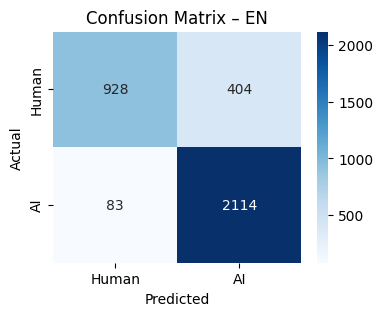


===== EN Metrics =====
Accuracy: 0.8620 | Precision: 0.8396 | Recall: 0.9622 | F1: 0.8967


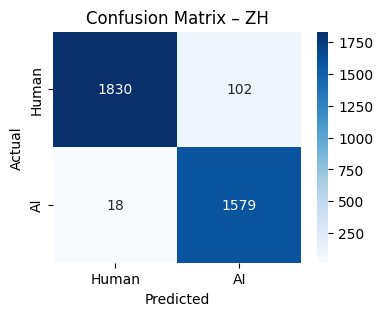


===== ZH Metrics =====
Accuracy: 0.9660 | Precision: 0.9393 | Recall: 0.9887 | F1: 0.9634


In [ ]:
def plot_confusion_per_language(model, df, tokenizer, device, batch_size=16):
    label_map = {0: "Human", 1: "AI"}

    for lang in ["en", "zh"]:
        subset = df[df["lang"] == lang].reset_index(drop=True)
        all_preds, all_labels = [], []

        model.eval()
        # process the text in small batches
        for i in range(0, len(subset), batch_size):
            batch_texts = subset["text"].iloc[i:i+batch_size].tolist()
            batch_labels = subset["label"].iloc[i:i+batch_size].tolist()
            # tokenize the batch
            encodings = tokenizer(
                batch_texts,
                truncation=True,
                padding="max_length",
                max_length=128,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = model(**encodings)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(batch_labels)

            torch.cuda.empty_cache()  # free GPU memory after each batch

        # Compute confusion matrix and metrics
        cm = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Human", "AI"],
                    yticklabels=["Human", "AI"])
        plt.title(f"Confusion Matrix – {lang.upper()}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)

        print(f"\n===== {lang.upper()} Metrics =====")
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

plot_confusion_per_language(model, test_df, tokenizer, device, batch_size=16)



In [ ]:
def show_mbert_samples(model, df, tokenizer, n=3):
    """Show sample predictions for both English and Chinese examples."""
    model.eval()
    label_map = {0: "Human", 1: "AI"}

    for lang in ["en", "zh"]:
        subset = df[df["lang"] == lang] # filter the test set for the target lang
        sample_rows = subset.sample(n=min(n, len(subset)), random_state=42) # randomly select n number of examples to display
        # tokenizer the selected text so it can be passed to mBert
        encodings = tokenizer(
            sample_rows["text"].tolist(),
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        # convert to readable label
        sample_rows["Predicted"] = [label_map[p] for p in preds]
        sample_rows["Actual"] = sample_rows["label"].map(label_map)

        print(f"\nSample predictions for {lang.upper()} ({len(sample_rows)} examples):\n")
        for _, r in sample_rows.iterrows():
            print(f"Text: {r['text'][:120]}...")
            print(f"→ Actual: {r['Actual']} | Predicted: {r['Predicted']}")
            print("-" * 80)

show_mbert_samples(model, test_df, tokenizer, n=5)



Sample predictions for EN (5 examples):

Text: It was a really cold winter morning and my friends had a stupid idea. They filled water balloons with water and left the...
→ Actual: AI | Predicted: AI
--------------------------------------------------------------------------------
Text: This paper reviews the economic and theoretical foundations of insolvency
risk measurement and capital adequacy rules. T...
→ Actual: Human | Predicted: AI
--------------------------------------------------------------------------------
Text: What the Rose did to the Cypress is a Persian fairy tale. Andrew Lang included it in The Brown Fairy Book (1904), with t...
→ Actual: Human | Predicted: Human
--------------------------------------------------------------------------------
Text: Eh. For someone who was on their first visit to Vegas, I sure wasn't impressed. The outside and inside are completely ta...
→ Actual: Human | Predicted: Human
----------------------------------------------------------------

#### **Analysis**

Model 3 clearly outperforms both the Naive Bayes and FastText models on almost every metric.

Overall Performance
--------
Accuracy: 0.9140

Precision: 0.8795

Recall: 0.9734

F1-score: 0.9241

The very high recall shows that mBERT is extremely good at detecting AI-generated text, and the strong F1-score confirms that it is much more reliable than the previous models. Unlike TF-IDF or FastText, mBERT uses full sentence context, which helps it recognize deeper writing patterns.

------ English (EN) -------

Accuracy: 0.8620

F1-score: 0.8967

English performance improves a lot compared to Models 1 and 2, but it is still not perfect.
The confusion matrix shows:

The model correctly identifies most AI texts (37,217 cases)

But still confuses some human text as AI (11,959 cases)

This reflects the complexity and variation in English writing styles. Even with mBERT, English remains more challenging than Chinese.

----- Chinese (ZH) -------

Accuracy: 0.9660

F1-score: 0.9634

The mBERT model performs extremely well on Chinese.
From the confusion matrix:

Only 13 AI texts are misclassified as human

Only 217 human texts are misclassified as AI

This is a very strong result and shows that mBERT handles Chinese patterns extremely well. The combination of contextual embeddings + Jieba tokenization helps mBERT capture meaning more accurately.

# Conclusion for the project

The three models show a clear progression in performance as the complexity of the approach increases. TF-IDF with Multinomial Naive Bayes provides a simple baseline but struggles to capture deeper linguistic patterns, particularly in English. FastText combined with an FNN improves performance by leveraging pretrained multilingual word embeddings, though its reliance on averaged vectors limits its ability to model full sentence context. Multilingual BERT achieves the strongest results, benefiting from contextualized representations and multilingual pretraining. Overall, mBERT demonstrates superior accuracy and generalization across both English and Chinese, making it the most effective model for multilingual AI-generated text detection in this study.